In [1]:
import pandas as pd
import seaborn as sn
import copy
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import time

#from plot_confusion_matrix import plot_confusion_matrix


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Define model

In [2]:
class NeuralNet(torch.nn.Module):
    def __init__(self, num_in_features):
        super(NeuralNet, self).__init__()
        self.classify = torch.nn.Sequential(
            torch.nn.Linear(in_features = num_in_features, out_features = 10),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features = 10, out_features = 10),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features = 10, out_features = 1))  
        self.activation = torch.nn.Sigmoid()
            
    def forward(self,x):
        x = self.classify(x)
        x = self.activation(x)
        return x

## Function for training and testing model

In [3]:
def loss_batch(model, xb, yb, loss_func=None, opt=None, weight = None, gamma=None, device=None):
    '''
    Calculate loss and do backpropagation, also for calculating results
    '''
    yhat_array = model(xb).detach().cpu().numpy()
    y_array = yb.long().cpu().numpy()
    pre_label = yhat_array.copy()
    pre_label[pre_label>=0.5] = 1
    pre_label[pre_label<0.5] = 0
    
    ra_score = roc_auc_score(y_array, yhat_array)
    recall = recall_score(y_array, pre_label)
    precision = precision_score(y_array, pre_label, zero_division=1)
    
    if opt is not None:
        # Train mode
        result = model(xb).squeeze()
        # Class imbalanced weight
        class_weight = weight[y_array]
        class_weight = class_weight.to(device)
        # Focal loss weight
        weight_ = torch.pow(1-result, gamma)
        weight_ = weight_.to(device)
        
        loss = loss_func(result, yb.float())
        loss_class_weighted = (loss*weight_*class_weight).mean()
        
        loss_class_weighted.backward()
        opt.step()
        opt.zero_grad()

        return loss.item(), ra_score, recall, precision, len(xb)

    # Test mode
    
    return ra_score, recall, precision, pre_label
        
def fit(epochs, model, loss_func, opt, train_dl, test_dl, device, weight, gamma):
    '''
    Train the model and record the history
    '''
    
    startTime = time.time()
    train_ra_score_list = [0]*epochs
    test_ra_score_list = [0]*epochs
    train_recall_list = [0]*epochs
    test_recall_list = [0]*epochs
    train_precision_list = [0]*epochs
    test_precision_list = [0]*epochs
   
    for epoch in range(0,epochs):        
        # train phase
        model.train()
        losses, ra_score, recall, precision, nums = zip(*[loss_batch(model, xb.to(device), yb.to(device), 
                                                  loss_func, opt, weight, gamma, device) for xb, yb in train_dl])
        train_ra_score_list[epoch] = sum(ra_score) / len(nums)
        train_recall_list[epoch] = sum(recall) / len(nums)
        train_precision_list[epoch] = sum(precision) / len(nums)
        
        # test phase
        test_ra_score_list[epoch], test_recall_list[epoch], test_precision_list[epoch], _ = test_model(model, test_dl)
        print('Epoch ', (epoch+1), '.')
        print('ROC AUC score: ', train_ra_score_list[epoch], ' | ', test_ra_score_list[epoch])
        print('Recall: ', train_recall_list[epoch], ' | ', test_recall_list[epoch])
        print('Precision: ', train_precision_list[epoch], ' | ', test_precision_list[epoch])

    endTime = time.time()
    print('It costs '+str(endTime-startTime)+' seconds.')
    
    return train_ra_score_list, test_ra_score_list, train_recall_list, test_recall_list, train_precision_list, test_precision_list

def plot_result(model_name, epochs, train_ra_score, test_ra_score, train_recall, test_recall, train_precision, test_precision, ra_fileName=None, recall_fileName=None, precision_fileName=None):
    '''
    Plot the training and validation performance
    '''

    epoch_range = [i for i in range(1,epochs+1)]
    plot_metrics(model_name, epoch_range, train_ra_score, test_ra_score, 'ROC_AUC')
    plot_metrics(model_name, epoch_range, train_recall, test_recall, 'Recall')
    plot_metrics(model_name, epoch_range, train_precision, test_precision, 'Precision')
        
def plot_metrics(model_name, epoch_range, train_score, test_score, metric_name):
    
    plt.figure()
    plt.plot(epoch_range,train_score, epoch_range,test_score)
    plt.xlabel('Epoch')
    plt.ylabel('%s'%(metric_name))
    plt.title('%s, %s'%(model_name, metric_name))
    plt.legend(labels = ['Train', 'Validate'])
    print('Max Val %s :%f'%(metric_name, max(test_score)))
    plt.savefig('./Images/%s_%s.png'%(model_name, metric_name))


In [4]:
def test_model(model, test_dl):
    '''
    Test the model
    '''
    with torch.no_grad():
        model.eval()
        ra_score, recall, precision, pre_labels = zip(*[loss_batch(model, xb.to(device), yb.to(device)) for xb, yb in test_dl])
        
    
    # only one batch for test dataloader
    test_ra_score = ra_score[0]
    test_recall = recall[0]
    test_precision = precision[0]
    pre_labels = pre_labels[0]
    
    
    return test_ra_score, test_recall, test_precision, pre_labels

## Function for pre-processing the data


In [5]:
def timeFeatures(df):
    '''
    Extract time features from click_time
    '''
    
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df["doy"]      = df["datetime"].dt.dayofyear
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

In [6]:
def prepare_data(path, with_LDA=False):
    '''
    Load adtracking information and split into input data and labels
    '''
    start_time = time.time()
    
    train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32'
            }
    data = pd.read_csv(path, usecols=train_columns, 
                       dtype = dtypes)
    print('[{}] Finished to load data'.format(time.time() - start_time))
    
    start_time = time.time()
    # split input_data and label
    labels = data[['is_attributed']].values
    data.drop(['is_attributed'], axis=1, inplace=True)
    
    # Count the number of clicks by ip
    ip_count = data.groupby(['ip'])['channel'].count().reset_index()
    ip_count.columns = ['ip', 'click_by_ip']
    data = pd.merge(data, ip_count, on='ip', how='left', sort=False)
    data['click_by_ip'] = data['click_by_ip'].astype('uint16')
    data.drop(['ip'], axis=1, inplace=True)
    
    # Extract time features
    data = timeFeatures(data)
    input_data = data.values # Transform to numpy array
    print('[{}] Finished to preprocess data'.format(time.time() - start_time))
    
    start_time = time.time()
    X_train, X_test, Y_train, Y_test = train_test_split(input_data, labels,
                                                        test_size=0.1, random_state=42, stratify=labels)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                        test_size=0.1, random_state=33, stratify=Y_train)
    print('[{}] Finished to split data'.format(time.time() - start_time))
    
    if with_LDA:
        print('Concatenating orignal features with LDA projection')
        # Project data using LDA
        projection_model = LDA()
        projection_model.fit(X_train, Y_train.flatten())
        LDA_X_train = projection_model.transform(X_train)
        LDA_X_val = projection_model.transform(X_val)
        LDA_X_test = projection_model.transform(X_test)

        # Concatenate LDA value to the original data
        X_train = np.concatenate((X_train, LDA_X_train), axis=1)
        X_val = np.concatenate((X_val, LDA_X_val), axis=1)
        X_test = np.concatenate((X_test, LDA_X_test), axis=1)
    
    # flatten labels in order to fit BCELoss
    Y_train = Y_train.flatten()
    Y_val = Y_val.flatten()
    Y_test = Y_test.flatten()
    print('X_train: ', X_train.shape)
    print('X_val: ', X_val.shape)
    print('X_test: ', X_test.shape)
    
    print('Y_train: ', Y_train.shape)
    print('Y_val: ', Y_val.shape)
    print('Y_test: ', Y_test.shape)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test


In [7]:
def prepare_small_data():
    X, y = make_classification(n_samples=100000, n_features=100, n_redundant=0,
    n_clusters_per_class=2, weights=[0.99], flip_y=0, random_state=4)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, 
                                                       test_size = 0.1, random_state=42, stratify=y)
    
    print(X_train.shape)
    print(X_test.shape)
    print(Y_train.shape)
    print(Y_test.shape)
    return X_train, X_test, Y_train, Y_test

## Oversampling

In [8]:
def oversampling(X_train, Y_train, resampling_mode):
    
    if resampling_mode == 'ROS':
        sampler = RandomOverSampler(random_state=42) # change to RandomOverSampler when using Random Over Sampling
    elif resampling_mode == 'SMOTE':
        sampler = SMOTE(random_state=42)
    elif resampling_mode == 'BorderlineSMOTE':
        sampler = BorderlineSMOTE(random_state=42, n_jobs=10)
    X_train_resample, Y_train_resample = sampler.fit_resample(X_train, Y_train)
    
    X_train_resample, _,Y_train_resample,_ = train_test_split(X_train_resample, Y_train_resample, test_size=1,random_state=42)
    print(X_train_resample.shape)
    print(Y_train_resample.shape)
    return X_train_resample, Y_train_resample

## Main function

In [9]:
# Choose to use LDA or Resampling
with_LDA = False
with_resampling = False

# wrap up training and testing data
print('Loading data...')
path = './talkingdata-adtracking-fraud-detection/trainset.csv'
train_data, val_data, test_data, train_label, val_label, test_label = prepare_data(path, with_LDA=with_LDA)

if with_resampling:
    resampling_modes = ['ROS','SMOTE','BorderlineSMOTE']
    resampling_mode = resampling_modes[1]
    print('Resampling data using ' + resampling_mode)
    train_data, train_label = oversampling(train_data, train_label, resampling_mode)
    print(sum(train_label[1:10000]))

print('Data preprocessing Finished.')

(train_dataTS, train_labelTS, val_dataTS, val_labelTS, test_dataTS, test_labelTS) = map(
        torch.from_numpy, (train_data, train_label, val_data, val_label, test_data, test_label))
[train_dataTS, train_labelTS, val_dataTS, val_labelTS, test_dataTS, test_labelTS] = \
    [x.to(device=device) for x in [train_dataTS, train_labelTS, val_dataTS, val_labelTS, test_dataTS, test_labelTS]]
    

[train_dataset, val_dataset, test_dataset] = map(
        Data.TensorDataset, [train_dataTS.float(), val_dataTS.float(), test_dataTS.float()], [train_labelTS, val_labelTS, test_labelTS])

batchSize = 50000
train_dl = Data.DataLoader(train_dataset, batch_size=batchSize)
val_dl = Data.DataLoader(val_dataset, batch_size=len(val_label))
test_dl = Data.DataLoader(test_dataset, batch_size=len(test_label))

Loading data...
[5.093934774398804] Finished to load data
[6.226357936859131] Finished to preprocess data
[111.73980474472046] Finished to split data
X_train:  (8100000, 7)
X_val:  (900000, 7)
X_test:  (1000000, 7)
Y_train:  (8100000,)
Y_val:  (900000,)
Y_test:  (1000000,)
Data preprocessing Finished.


--------------Model 0---------------
Weight:  tensor([1, 1])
Gamma:  0
[Sun Mar 15 21:32:46 2020]Training the model...
Epoch  1 .
ROC AUC score:  0.6124023182934764  |  0.6747025024014583
Recall:  0.12723811422928158  |  0.0
Precision:  0.3215574433529209  |  0.0
Epoch  2 .
ROC AUC score:  0.7017295550871426  |  0.7457079323794444
Recall:  6.858710562414266e-05  |  0.0005938242280285036
Precision:  0.6450617283950617  |  0.04
Epoch  3 .
ROC AUC score:  0.7580147876080736  |  0.7640853447541787
Recall:  0.008032902677055523  |  0.022565320665083134
Precision:  0.38844062316284556  |  0.5205479452054794
Epoch  4 .
ROC AUC score:  0.7633743563455934  |  0.7710696460029263
Recall:  0.017907530145645882  |  0.027909738717339667
Precision:  0.5122158534195571  |  0.5053763440860215
Epoch  5 .
ROC AUC score:  0.7663153344059881  |  0.7742667749269447
Recall:  0.021491989887670378  |  0.032660332541567694
Precision:  0.5449563981971389  |  0.5612244897959183
Epoch  6 .
ROC AUC score:  0.768115

Epoch  48 .
ROC AUC score:  0.8043904475442751  |  0.8099828961176117
Recall:  0.08100806195495969  |  0.08491686460807601
Precision:  0.6300518379544578  |  0.6651162790697674
Epoch  49 .
ROC AUC score:  0.8073223236550617  |  0.8125454416508168
Recall:  0.08542311936577747  |  0.08788598574821853
Precision:  0.6393986008875479  |  0.6636771300448431
Epoch  50 .
ROC AUC score:  0.8108557576925621  |  0.81693861062323
Recall:  0.0888827913653241  |  0.08669833729216152
Precision:  0.6398872144554733  |  0.6547085201793722
It costs 5740.972782373428 seconds.
Max Val ROC_AUC :0.834970
Max Val Recall :0.134204
Max Val Precision :0.708333
Confusion matrix:
[[898239     77]
 [  1538    146]]
------------Test Model 0------------
Weight:  tensor([1, 1])
Gamma:  0
Confusion matrix:
[[998048     80]
 [  1721    151]]
ROC AUC:  0.8156901758018359
Recall:  0.08066239316239317
Precision:  0.6536796536796536


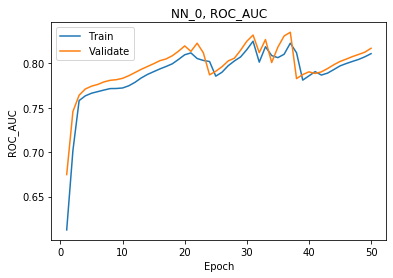

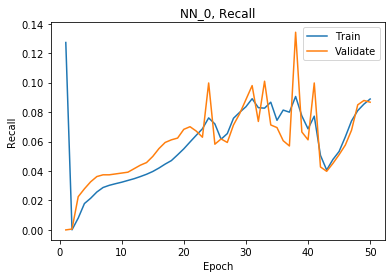

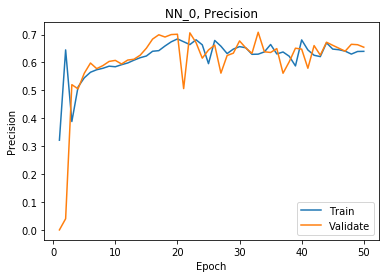

In [10]:
#--------------------NeuralNet---------------------
ratio_minority = sum(train_label) / len(train_label)

# cost-sensitive weight
weight_list = [torch.tensor([1, 1]),
    torch.tensor([(ratio_minority*100), (1-ratio_minority)*100]),
    torch.tensor([ratio_minority, 1-ratio_minority]),
    torch.tensor([1, 1/ratio_minority])]

# focal loss parameter
gamma_list = list(range(5))

# For tuning parameter
category = 1

loss_func = nn.BCELoss(reduce=None)
epochs = 50
learning_rate = 0.001
train_ra_score = np.zeros((category, epochs))
val_ra_score = np.zeros((category, epochs))
train_recall = np.zeros((category, epochs))
val_recall = np.zeros((category, epochs))
train_precision = np.zeros((category, epochs))
val_precision = np.zeros((category, epochs))
model_list = []

for i in range(category):
    print('--------------Model %d---------------'%(i))
    weight = weight_list[0]
    print('Weight: ', weight)
    gamma = gamma_list[0]
    print('Gamma: ',gamma) 
    
    model = NeuralNet(train_data.shape[1]).to(device=device)
    opt = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

    # Train the model
    print('[%s]Training the model...'%(time.ctime()))
    model_name = 'NN_%d'%(i)
    train_ra_score[i,:], val_ra_score[i,:] , train_recall[i,:], val_recall[i,:], train_precision[i,:], \
        val_precision[i,:]=fit(epochs, model, loss_func, opt, train_dl, val_dl, device, weight, gamma)
    plot_result(model_name, epochs, train_ra_score[i,:], val_ra_score[i,:], 
                train_recall[i,:], val_recall[i,:], train_precision[i,:], val_precision[i,:])

    # Validate the model
    _, _, _, pre_label = test_model(model, val_dl)
    cm = confusion_matrix(val_label, pre_label)
    print('Confusion matrix:')
    print(cm)
    
    model_list.append(copy.deepcopy(model))
    
    torch.cuda.empty_cache()
    
# Use the model with best AUC to test
val_precision[np.where(val_precision==1)] = 0
best_model_index = np.argmax(val_ra_score[:,-1]+val_recall[:,-1]+val_precision[:,-1])
model = model_list[best_model_index]
print('------------Test Model %d------------'%(best_model_index))
print('Weight: ', weight)
print('Gamma: ',gamma) 

# Test the model
ra_score, recall, precision, pre_label = test_model(model, test_dl)
cm = confusion_matrix(test_label, pre_label)
print('Confusion matrix:')
print(cm)
print('ROC AUC: ', ra_score)
print('Recall: ', recall)
print('Precision: ', precision)
